In [158]:
!python -V

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.dates as mdates
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)

Python 3.13.3


In [159]:
def download_data(ticker="BTC-USD", start_date="2020-01-01", end_date=None):
    if end_date is None:
        end_date = pd.Timestamp.now().strftime('%Y-%m-%d')
    
    data = yf.download(ticker, start=start_date, end=end_date)
    data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
    
    data['SMA_7'] = data['Close'].rolling(window=7).mean()
    data['SMA_30'] = data['Close'].rolling(window=30).mean()
    data['RSI'] = compute_rsi(data['Close'], 14)
    data['MACD'] = compute_macd(data['Close'])
    
    data = data.dropna()
    return data

def compute_rsi(series, window):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def compute_macd(series, fast=12, slow=26, signal=9):
    ema_fast = series.ewm(span=fast).mean()
    ema_slow = series.ewm(span=slow).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal).mean()
    return macd_line - signal_line

def create_sequences(data, target_col_idx=3, seq_length=60, forecast_horizon=1):
    X, y = [], []
    
    for i in range(len(data) - seq_length - forecast_horizon + 1):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length:i+seq_length+forecast_horizon, target_col_idx])
    
    return np.array(X), np.array(y)


ticker = "BTC-USD"
data = download_data(ticker)
close_col_idx = data.columns.get_loc('Close')

scaler = RobustScaler()
scaled_data = scaler.fit_transform(data)

seq_length = 60
forecast_horizon = 30  # Прогноз на 30 дней
X, y = create_sequences(scaled_data, target_col_idx=close_col_idx, 
                       seq_length=seq_length, forecast_horizon=forecast_horizon)

train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

[*********************100%***********************]  1 of 1 completed


In [160]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2, forecast_horizon=30):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.forecast_horizon = forecast_horizon
        
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size * forecast_horizon)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.rnn(x, h0) 
        out = out[:, -1, :]
        out = self.fc(out)
        out = out.view(out.size(0), self.forecast_horizon, -1)
        return out
    
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2, forecast_horizon=30):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.forecast_horizon = forecast_horizon

        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size * forecast_horizon)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        out = out.view(out.size(0), self.forecast_horizon, -1)
        return out

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2, forecast_horizon=30):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.forecast_horizon = forecast_horizon
        
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size * forecast_horizon)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        out = out.view(out.size(0), self.forecast_horizon, -1)
        return out

In [ ]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=100, patience=15, device='cpu'):
    model.to(device)
    best_loss = float('inf')
    no_improve = 0
    train_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        # Ранняя остановка
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            no_improve = 0
            torch.save(model.state_dict(), f'best_{model.__class__.__name__}.pth')
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f'Early stopping at epoch {epoch}')
                break
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {epoch_loss:.6f}')
    
    return train_losses

input_size = X_train.shape[2]
hidden_size = 128
num_layers = 3
output_size = forecast_horizon
dropout = 0.3
learning_rate = 0.001
num_epochs = 150

rnn_model = RNNModel(input_size, hidden_size, num_layers, output_size, dropout)
lstm_model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout)
gru_model = GRUModel(input_size, hidden_size, num_layers, output_size, dropout)

criterion = nn.MSELoss()

rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=learning_rate)
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)
gru_optimizer = optim.Adam(gru_model.parameters(), lr=learning_rate)


In [162]:
print("Training RNN model...")
rnn_losses = train_model(rnn_model, train_loader, criterion, rnn_optimizer, num_epochs)

Training RNN model...
Epoch 0, Loss: 0.072531
Epoch 10, Loss: 0.019487
Epoch 20, Loss: 0.018105
Epoch 30, Loss: 0.017537
Epoch 40, Loss: 0.016033
Epoch 50, Loss: 0.017038
Early stopping at epoch 55


In [163]:
print("\nTraining LSTM model...")
lstm_losses = train_model(lstm_model, train_loader, criterion, lstm_optimizer, num_epochs)


Training LSTM model...
Epoch 0, Loss: 0.119423
Epoch 10, Loss: 0.015871
Epoch 20, Loss: 0.008064
Epoch 30, Loss: 0.003827
Epoch 40, Loss: 0.002765
Epoch 50, Loss: 0.002194
Epoch 60, Loss: 0.001953
Epoch 70, Loss: 0.001437
Epoch 80, Loss: 0.001305
Epoch 90, Loss: 0.001297
Epoch 100, Loss: 0.001215
Epoch 110, Loss: 0.001198
Epoch 120, Loss: 0.000999
Epoch 130, Loss: 0.000964
Epoch 140, Loss: 0.000955


In [164]:
print("\nTraining GRU model...")
gru_losses = train_model(gru_model, train_loader, criterion, gru_optimizer, num_epochs)


Training GRU model...
Epoch 0, Loss: 0.086908
Epoch 10, Loss: 0.014859
Epoch 20, Loss: 0.009768
Epoch 30, Loss: 0.004275
Epoch 40, Loss: 0.003163
Epoch 50, Loss: 0.002439
Epoch 60, Loss: 0.001958
Epoch 70, Loss: 0.001750
Epoch 80, Loss: 0.001641
Epoch 90, Loss: 0.001471
Epoch 100, Loss: 0.001461
Epoch 110, Loss: 0.001325
Epoch 120, Loss: 0.001248
Epoch 130, Loss: 0.001246
Epoch 140, Loss: 0.001259


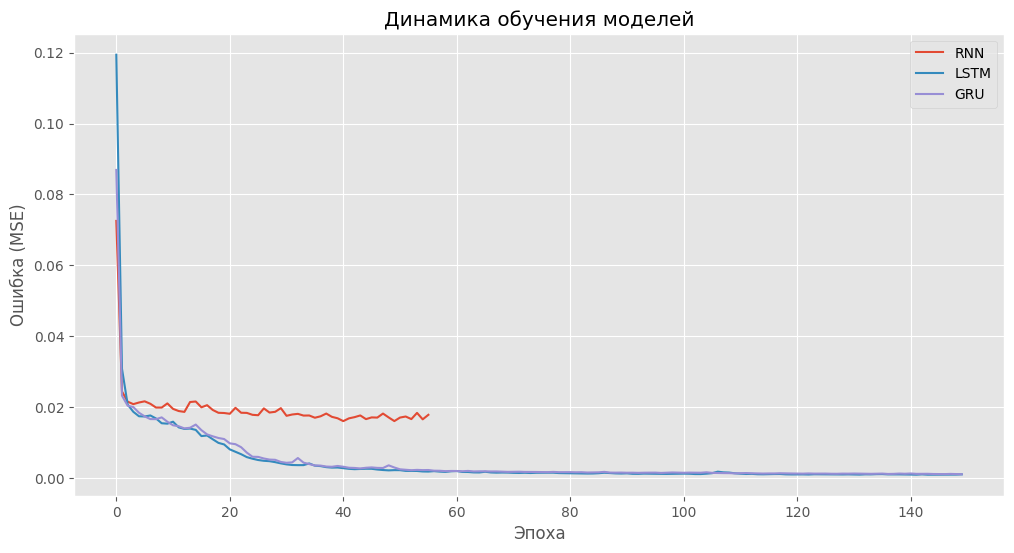

In [165]:
# Графики потерь при обучении
plt.figure(figsize=(12, 6))
plt.plot(rnn_losses, label='RNN')
plt.plot(lstm_losses, label='LSTM')
plt.plot(gru_losses, label='GRU')
plt.title('Динамика обучения моделей')
plt.xlabel('Эпоха')
plt.ylabel('Ошибка (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [166]:
def evaluate_model(model, X_test, y_test, scaler, data, target_col='Close'):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test)

    predictions_np = predictions.numpy()
    y_test_np = y_test.numpy()

    target_idx = data.columns.get_loc(target_col)

    mse_list = []
    mae_list = []

    base_data = data.iloc[-len(predictions_np):].values.copy()

    for step in range(predictions_np.shape[1]):
        dummy_pred = base_data.copy()
        dummy_true = base_data.copy()

        dummy_pred[:, target_idx] = predictions_np[:, step, 0].reshape(-1, 1)
        dummy_true[:, target_idx] = y_test_np[:, step, 0].reshape(-1, 1)

        pred_inv = scaler.inverse_transform(dummy_pred)[:, target_idx]
        true_inv = scaler.inverse_transform(dummy_true)[:, target_idx]

        mse_list.append(mean_squared_error(true_inv, pred_inv))
        mae_list.append(mean_absolute_error(true_inv, pred_inv))

    avg_mse = np.mean(mse_list)
    avg_mae = np.mean(mae_list)

    print(f"{model.__class__.__name__} Results:")
    print(f"MSE: {avg_mse:.2f}")
    print(f"MAE: {avg_mae:.2f}")

    plt.figure(figsize=(12, 6))
    plt.plot(data.index[-len(true_inv):], true_inv, label='Реальные значения')
    plt.plot(data.index[-len(pred_inv):], pred_inv, label='Предсказания')
    plt.title(f'Прогноз vs Реальные значения ({model.__class__.__name__})')
    plt.xlabel('Дата')
    plt.ylabel('Цена (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return avg_mse, avg_mae


RNNModel Results:
MSE: 634469499.02
MAE: 21350.96


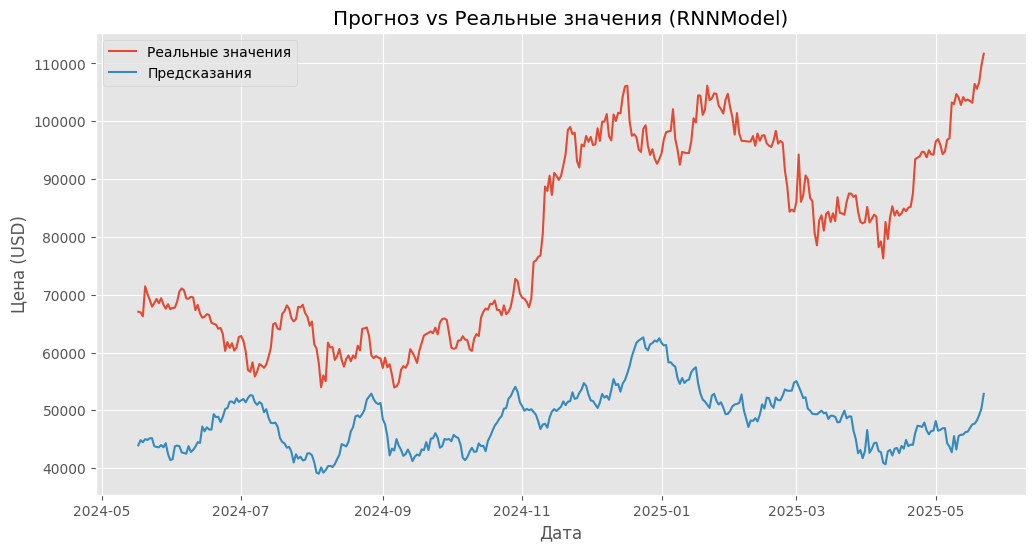

LSTMModel Results:
MSE: 929092771.45
MAE: 27391.38


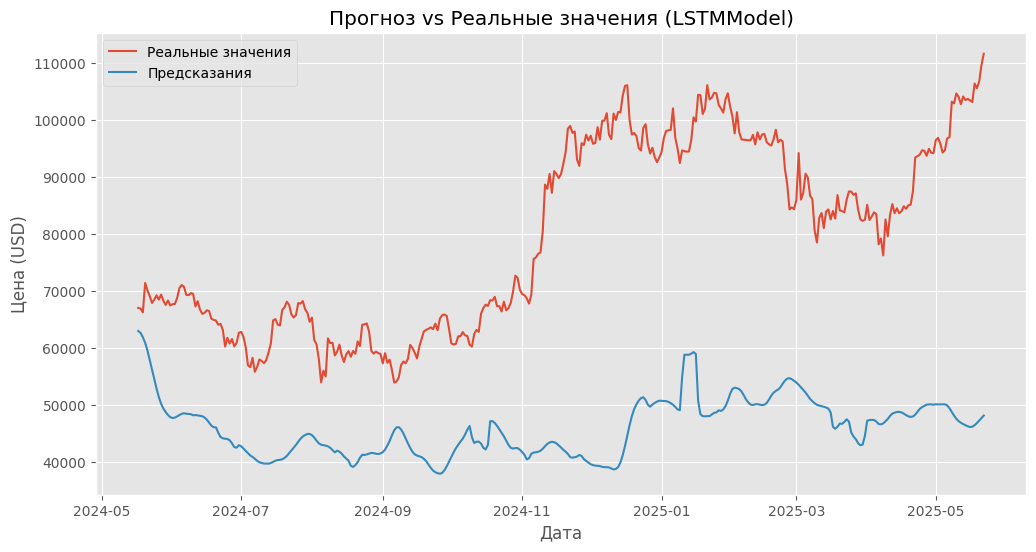

GRUModel Results:
MSE: 835824434.33
MAE: 25902.77


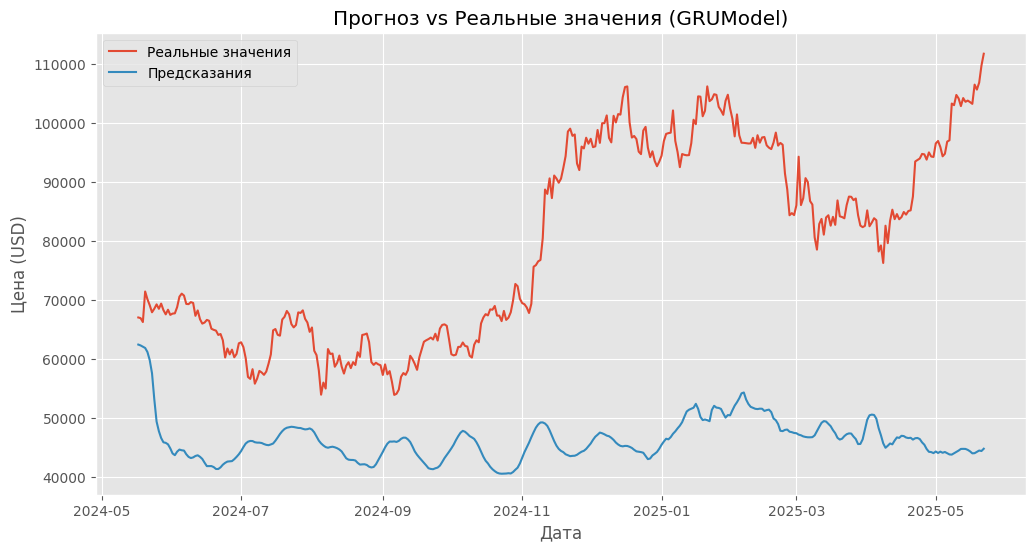

In [167]:
rnn_model.load_state_dict(torch.load('best_RNNModel.pth'))
lstm_model.load_state_dict(torch.load('best_LSTMModel.pth'))
gru_model.load_state_dict(torch.load('best_GRUModel.pth'))

rnn_mse, rnn_mae = evaluate_model(rnn_model, X_test_tensor, y_test_tensor, scaler, data)
lstm_mse, lstm_mae = evaluate_model(lstm_model, X_test_tensor, y_test_tensor, scaler, data)
gru_mse, gru_mae = evaluate_model(gru_model, X_test_tensor, y_test_tensor, scaler, data)


Сравнение моделей:
  Model           MSE           MAE
0   RNN  6.344695e+08  21350.960964
1  LSTM  9.290928e+08  27391.375163
2   GRU  8.358244e+08  25902.772167


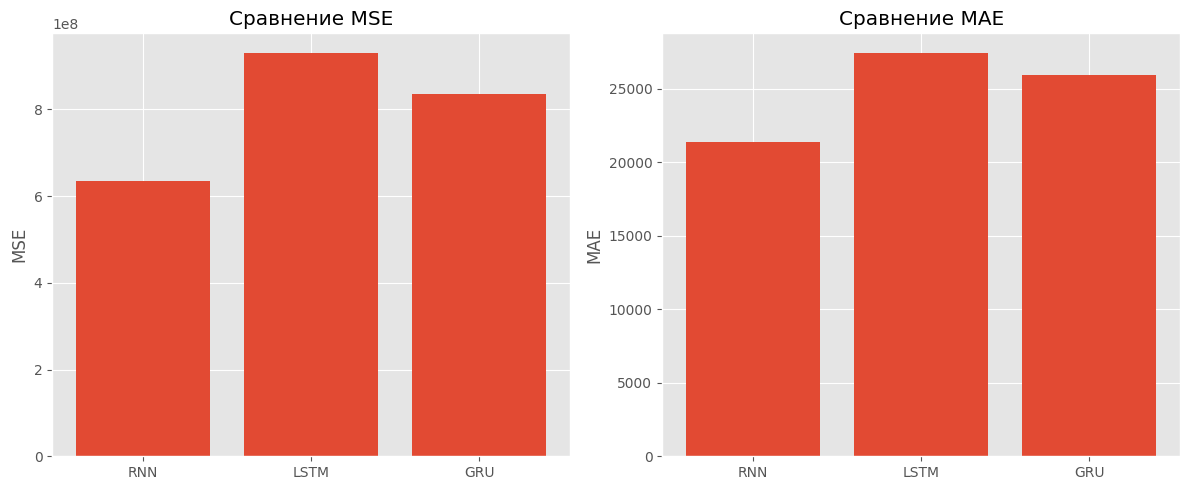

In [168]:
# Сравнение метрик
metrics = {
    'Model': ['RNN', 'LSTM', 'GRU'],
    'MSE': [rnn_mse, lstm_mse, gru_mse],
    'MAE': [rnn_mae, lstm_mae, gru_mae]
}

metrics_df = pd.DataFrame(metrics)
print("\nСравнение моделей:")
print(metrics_df)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(metrics_df['Model'], metrics_df['MSE'])
plt.title('Сравнение MSE')
plt.ylabel('MSE')

plt.subplot(1, 2, 2)
plt.bar(metrics_df['Model'], metrics_df['MAE'])
plt.title('Сравнение MAE')
plt.ylabel('MAE')

plt.tight_layout()
plt.show()

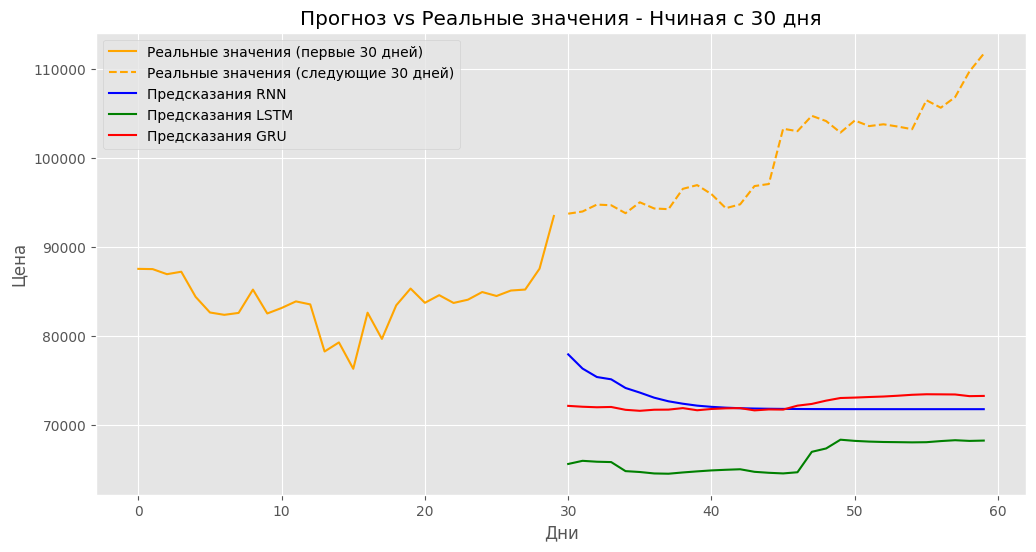

In [174]:
def forecast(model, initial_sequence, scaler, seq_length=60, forecast_horizon=30, n_days=30, device='cpu'):
    model.eval()
    model.to(device)
    
    current_seq = initial_sequence.copy()
    predictions_scaled = []
    
    with torch.no_grad():
        for _ in range(n_days):
            x = torch.FloatTensor(current_seq).unsqueeze(0).to(device)
            pred = model(x)
            pred = pred.squeeze(0).cpu().numpy()
            
            next_pred = pred[0, 0]
            
            next_row = current_seq[-1].copy()
            next_row[close_col_idx] = next_pred
            
            current_seq = np.vstack([current_seq[1:], next_row])
            
            predictions_scaled.append(next_pred)
    
    dummy = np.zeros((n_days, initial_sequence.shape[1]))
    predictions_scaled = np.array(predictions_scaled).reshape(-1, 1)
    dummy[:, close_col_idx] = predictions_scaled
    predictions_unscaled = scaler.inverse_transform(dummy)[:, close_col_idx]
    
    return predictions_unscaled

initial_seq = scaled_data[-seq_length:]

preds_rnn = forecast(rnn_model, initial_seq, scaler, seq_length=seq_length, forecast_horizon=forecast_horizon,
                 n_days=30, device='cpu')

preds_lstm = forecast(lstm_model, initial_seq, scaler, seq_length=seq_length, forecast_horizon=forecast_horizon,
                 n_days=30, device='cpu')

preds_gru = forecast(gru_model, initial_seq, scaler, seq_length=seq_length, forecast_horizon=forecast_horizon,
                 n_days=30, device='cpu')

true_values = data['Close'].values[-60:]

plt.plot(range(30), true_values[:30], label='Реальные значения (первые 30 дней)', color='orange')

# Построение реальных значений (последние 30 дней) и предсказаний
plt.plot(range(30, 60), true_values[30:], label='Реальные значения (следующие 30 дней)', color='orange', linestyle='--')
plt.plot(range(30, 60), preds_rnn, label='Предсказания RNN', color='blue')
plt.plot(range(30, 60), preds_lstm, label='Предсказания LSTM', color='green')
plt.plot(range(30, 60), preds_gru, label='Предсказания GRU', color='red')

plt.title('Прогноз vs Реальные значения - Нчиная с 30 дня')
plt.xlabel('Дни')
plt.ylabel('Цена')
plt.legend()
plt.grid(True)
plt.show()

### 1. Ограниченность входных данных
Проблема: Модель использует только цены закрытия, игнорируя другие важные факторы.

Решение:
```python
data = yf.download(ticker, start="2020-01-01", end=pd.Timestamp.now().strftime('%Y-%m-%d'))
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]  # Используем больше признаков
```

### 2. Проблемы с нормализацией
Проблема: `MinMaxScaler` может искажать данные при выходе за границы.

Решение:

```python
# Использование RobustScaler для устойчивости к выбросам
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaled_data = scaler.fit_transform(data)
```

### 3. Накопление ошибок при прогнозировании
Проблема: Каждое следующее предсказание использует предыдущие предсказания, что накапливает ошибку.

Решение:
```python
# Если есть реальные значения, используем их вместо предсказаний
```

### 4. Улучшение процесса обучения
Проблема: Базовое обучение может быть неоптимальным.

Решение:

```python
# Ранняя остановка
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            no_improve = 0
```
